# Poem: Logistic Regression

For this project, the text is the feature and the label is the date of the poem.

We use logistic regression for a multi-class text classification task.

With no preprocessing, the model has 304 targets. We will present the results of different models depending on the preprocessing.

In [1]:
# If you do not have stopwords
import nltk
nltk.download("stopwords")


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f60b6c662a0>>
Traceback (most recent call last):
  File "/home/tofeha/miniconda3/envs/NLP1/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 
[nltk_data] Downloading package stopwords to /home/tofeha/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# 🎓 Library

In [1]:
# Misc
import os
import numpy as np
import pandas as pd
import pickle
import re

# Training
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline


# Plotting
import matplotlib.pyplot as plt 

DATA = "../data/"
BENCHMARK_TABLE = "../../class_bench.parquet"
RANDOM_STATE = 42

if not os.path.exists(DATA):
    raise FileNotFoundError(f"Data directory {DATA} does not exist. Please create it and add the data files.")

In [2]:
poems_df = pd.read_parquet(DATA + "de_poems.parquet")

In [3]:
poems_df.head(3)["text"].values

array(['Gebohrn, und wiederumb, o Mensch, gebohren werden,\nErrettet dich vom Tod und hilfft dir in Beschwerden.',
       'Es suchte niemand Gott, liegt er gleich unterm Leben,\nWär er nicht Lieb und hätt es nicht mit Lieb umbgeben.',
       'Die ist in Gott, und Gott der ist zugleich in Ihr,\nIn der ich leb, und die auch wieder lebt in mir.'],
      dtype=object)

# Preprocessing

In [4]:
import sys
sys.path.append("../")
from utils import get_period

poems = poems_df.copy()

# Transform all date to centuries, else we have 304 classes
poems["creation"] = poems["creation"].astype(int)

# For model A
poems["century"] = poems["creation"].apply(lambda x: str(x // 100 + 1))

# For model B
poems["movement"] = poems["creation"].apply(get_period)

def preprocess(text: str) -> str:
    text = text.lower()
    text = re.sub(r'[\d\W_]+', ' ', text)
    tokens = text.split()
    return ' '.join(tokens)

poems["cleaned_text"] = poems["text"].apply(preprocess)

In [5]:
poems.head(3)

,title,text,author,creation,century,movement,cleaned_text
0,94.Wieder Geburt,"Gebohrn, und wiederumb, o Mensch, gebohren wer...","Czepko von Reigersfeld, Daniel",1632,17,Baroque,gebohrn und wiederumb o mensch gebohren werden...
1,56.Liebe ist der Grund der Welt,"Es suchte niemand Gott, liegt er gleich unterm...","Czepko von Reigersfeld, Daniel",1632,17,Baroque,es suchte niemand gott liegt er gleich unterm ...
2,7.Gott ergebene Seele,"Die ist in Gott, und Gott der ist zugleich in ...","Czepko von Reigersfeld, Daniel",1632,17,Baroque,die ist in gott und gott der ist zugleich in i...


## Model creation and tuning

When calling the `fit` method of the model, the y parameter will be different (either century or movement).

We use SMOTE in order to create synthetic samples for the minority class (11th century).

This reduces accuracy, but increases F1 score.

In [6]:
# Remove german stop words
german_stop_words = stopwords.words("german")

# Pipeline to fine-tune encoding and model
# No need to fit_transform, pipeline will do it
pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(stop_words=german_stop_words, ngram_range=(1, 2), max_df = 0.9, max_features=350000)),
    # To keep the interesting features
    ("SMOTE", SMOTE(random_state=RANDOM_STATE)),
    ("clf", LogisticRegression(random_state = RANDOM_STATE, solver = "sag", penalty = "l2", max_iter = 100, verbose = 10, class_weight="balanced"))
])

x = poems["cleaned_text"]
# y will be defined depending on the model

In [7]:
# For overall better config: penalty = "L2", solver = "lbfgs", max_iter = 100, max_features = 350000, ngram_range(1, 2)
# For better accuracy on 19th, same thing with "sag"

# https://stackoverflow.com/questions/44066264/how-to-choose-parameters-in-tfidfvectorizer-in-sklearn-during-unsupervised-clust

# Hyperparameter grid
param_grid = [
    {
    #    "tfidf__max_df": [0.9, 1.0],
    #    "tfidf__ngram_range": [(1, 1), (1, 2), (1, 3)],
    #    "tfidf__max_features": [200000, 250000, 300000, 350000],
    #    "clf__class_weight": [None, "balanced"],
    #    "clf__class_weight": ["balanced", None],
    #    "clf__solver": ["lbfgs", "sag"],
    #    "clf__penalty": ["l1", "l2"],
    #    "clf__max_iter": [100, 350]
    }
]

clf = GridSearchCV(pipeline, param_grid, n_jobs = 2, cv = 3, verbose = True)


# Model A: SMOTE, Per Century

Each poem is mapped to a century.

Our feature is `text`, and the label is `century`.

## Step 1: Feature selection

In [8]:
y = poems["century"]

In [9]:
print(f"Currently have {len(poems)} poems with {len(y.unique())} dates.")

Currently have 71570 poems with 8 dates.


## Step 2: Data splitting and model training

In [10]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

In [11]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((57256,), (14314,), (57256,), (14314,))

### Data Augment

Execute only if you want to try the augmentation.


In [12]:
from utils import data_augment

shuffled_texts, shuffled_labels = data_augment(x_train, y_train)
x_train = pd.concat([x_train, pd.Series(shuffled_texts)], ignore_index=True)
y_train = pd.concat([y_train, pd.Series(shuffled_labels)], ignore_index=True)

### Training

In [12]:
clf.fit(x_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Epoch 1, change: 1
Epoch 1, change: 1
Epoch 2, change: 0.13862236
Epoch 2, change: 0.13171985
Epoch 3, change: 0.058339443
Epoch 3, change: 0.056322745
Epoch 4, change: 0.043497826
Epoch 4, change: 0.035161947
Epoch 5, change: 0.023540131
Epoch 5, change: 0.024318053
Epoch 6, change: 0.018784629
Epoch 6, change: 0.017720434
Epoch 7, change: 0.021717672
Epoch 7, change: 0.015834067
Epoch 8, change: 0.015173328
Epoch 8, change: 0.012662265
Epoch 9, change: 0.010439609
Epoch 9, change: 0.015027261
Epoch 10, change: 0.0098349655
Epoch 10, change: 0.014408403
Epoch 11, change: 0.0048897663
Epoch 11, change: 0.004144464
Epoch 12, change: 0.0052259454
Epoch 12, change: 0.010571597
Epoch 13, change: 0.0016937335
Epoch 13, change: 0.0020890463
Epoch 14, change: 0.0013650721
Epoch 14, change: 0.0013499982
Epoch 15, change: 0.0023065933
Epoch 15, change: 0.0043276376
Epoch 16, change: 0.00032454682
Epoch 16, change: 0.00068101694
Epoch 17

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:  1.4min
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:  1.4min


Epoch 21, change: 0.00012697295
convergence after 22 epochs took 87 seconds


[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:  1.5min
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:  1.5min


Epoch 1, change: 1
Epoch 2, change: 0.13673188
Epoch 3, change: 0.064395726
Epoch 4, change: 0.039293507
Epoch 5, change: 0.024538729
Epoch 6, change: 0.037136263
Epoch 7, change: 0.01537126
Epoch 8, change: 0.017346717
Epoch 9, change: 0.017720681
Epoch 10, change: 0.0075957831
Epoch 11, change: 0.0056375497
Epoch 12, change: 0.016723717
Epoch 13, change: 0.0072429828
Epoch 14, change: 0.0021810929
Epoch 15, change: 0.0009138082
Epoch 16, change: 0.00094222193
Epoch 17, change: 0.0022367025
Epoch 18, change: 0.00037685861
Epoch 19, change: 0.00018793112
Epoch 20, change: 0.00044275004
convergence after 21 epochs took 54 seconds


[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:   54.9s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:   54.9s


Epoch 1, change: 1
Epoch 2, change: 0.16032098
Epoch 3, change: 0.056255138
Epoch 4, change: 0.041194648
Epoch 5, change: 0.048732468
Epoch 6, change: 0.020771542
Epoch 7, change: 0.014660839
Epoch 8, change: 0.015962914
Epoch 9, change: 0.011530896
Epoch 10, change: 0.0087458973
Epoch 11, change: 0.0037163156
Epoch 12, change: 0.0019851127
Epoch 13, change: 0.0046620037
Epoch 14, change: 0.0011138302
Epoch 15, change: 0.00064493356
Epoch 16, change: 0.00067714176
Epoch 17, change: 0.00027559013
Epoch 18, change: 0.00010999486
convergence after 19 epochs took 88 seconds


[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:  1.5min
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:  1.5min


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(max_df=0.9,
                                                        max_features=350000,
                                                        ngram_range=(1, 2),
                                                        stop_words=['aber',
                                                                    'alle',
                                                                    'allem',
                                                                    'allen',
                                                                    'aller',
                                                                    'alles',
                                                                    'als',
                                                                    'also',
                                                                    'am', 'an',
                                                                    'ander',
                                                                    'andere',
                                                                    'anderem',
                                                                    'anderen',
                                                                    'anderer',
                                                                    'anderes',
                                                                    'anderm',
                                                                    'andern',
                                                                    'anderr',
                                                                    'anders',
                                                                    'auch',
                                                                    'auf',
                                                                    'aus',
                                                                    'bei',
                                                                    'bin',
                                                                    'bis',
                                                                    'bist',
                                                                    'da',
                                                                    'damit',
                                                                    'dann', ...])),
                                       ('SMOTE', SMOTE(random_state=42)),
                                       ('clf',
                                        LogisticRegression(class_weight='balanced',
                                                           random_state=42,
                                                           solver='sag',
                                                           verbose=10))]),
             n_jobs=2, param_grid=[{}], verbose=True)

In [13]:
century_model = clf.best_estimator_
century_model

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.9, max_features=350000,
                                 ngram_range=(1, 2),
                                 stop_words=['aber', 'alle', 'allem', 'allen',
                                             'aller', 'alles', 'als', 'also',
                                             'am', 'an', 'ander', 'andere',
                                             'anderem', 'anderen', 'anderer',
                                             'anderes', 'anderm', 'andern',
                                             'anderr', 'anders', 'auch', 'auf',
                                             'aus', 'bei', 'bin', 'bis', 'bist',
                                             'da', 'damit', 'dann', ...])),
                ('SMOTE', SMOTE(random_state=42)),
                ('clf',
                 LogisticRegression(class_weight='balanced', random_state=42,
                                    solver='sag', verbose=10))])

In [14]:
century_model.get_params()

{'memory': None,
 'steps': [('tfidf',
   TfidfVectorizer(max_df=0.9, max_features=350000, ngram_range=(1, 2),
                   stop_words=['aber', 'alle', 'allem', 'allen', 'aller', 'alles',
                               'als', 'also', 'am', 'an', 'ander', 'andere',
                               'anderem', 'anderen', 'anderer', 'anderes',
                               'anderm', 'andern', 'anderr', 'anders', 'auch',
                               'auf', 'aus', 'bei', 'bin', 'bis', 'bist', 'da',
                               'damit', 'dann', ...])),
  ('SMOTE', SMOTE(random_state=42)),
  ('clf',
   LogisticRegression(class_weight='balanced', random_state=42, solver='sag',
                      verbose=10))],
 'transform_input': None,
 'verbose': False,
 'tfidf': TfidfVectorizer(max_df=0.9, max_features=350000, ngram_range=(1, 2),
                 stop_words=['aber', 'alle', 'allem', 'allen', 'aller', 'alles',
                             'als', 'also', 'am', 'an', 'ander', 'andere'

#### Quick save

In [ ]:
pickle.dump(century_model, open("../trained/LR_Century_model_SMOTE_SAG.pkl", "wb"))

## Step 3: Evaluation

#### Quick load

In [ ]:
century_model = pickle.load(open("../trained/LR_Century_model_SMOTE_lbfgs.pkl", "rb"))

### Prediction

In [15]:
y_pred = century_model.predict(x_test)

### Metrics

In [16]:
print(classification_report(y_test,y_pred, zero_division=0))

results = classification_report(y_test, y_pred, zero_division=0, output_dict=True)

recall_avg = results["weighted avg"]["recall"]
f1_score_avg = results["weighted avg"]["f1-score"]
precision_avg = results["weighted avg"]["precision"]

              precision    recall  f1-score   support

          11       0.58      0.45      0.51        55
          13       0.89      0.44      0.59        18
          14       0.81      0.78      0.80       189
          16       0.97      0.83      0.90       210
          17       0.92      0.92      0.92      4032
          18       0.77      0.75      0.76      2880
          19       0.86      0.88      0.87      6476
          20       0.58      0.58      0.58       454

    accuracy                           0.85     14314
   macro avg       0.80      0.71      0.74     14314
weighted avg       0.85      0.85      0.85     14314



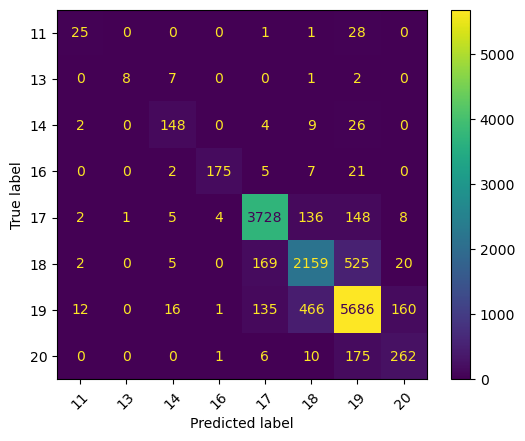

In [17]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

heat = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=century_model.classes_)
fig, ax = plt.subplots()  # optional: adjust figure size
heat.plot(ax=ax)
plt.xticks(rotation=45)
plt.show()

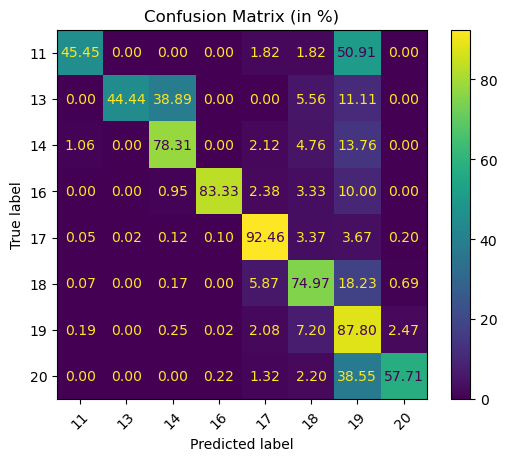

In [18]:
# Normalize it (row-wise percentages)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=century_model.classes_)
disp.plot(values_format='.2f')  # values_format to control decimal places
plt.title('Confusion Matrix (in %)')
plt.xticks(rotation=45)
plt.show()


In [19]:
# Compare the results with the actual y values
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.85


In [20]:
# Use predict_proba to get probabilities for each class
y_pred_proba = century_model.predict_proba(x_test)

# Compute ROC AUC score
avg_roc = roc_auc_score(y_test, y_pred_proba, average="macro", multi_class="ovr")
print(f"ROC AUC: {avg_roc:.2f}")

ROC AUC: 0.98


### Saving for benchmarking

In [21]:
benchmark = pd.read_parquet(BENCHMARK_TABLE)
benchmark.loc[("TF-IDF", "Logistic Regression"), ["Avg Recall", "Avg F1-Score", "Avg Precision", "Accuracy", "Avg AUC"]] = [
    recall_avg, f1_score_avg, precision_avg, accuracy, avg_roc
]


In [23]:
# Save the benchmark table
benchmark.to_parquet(BENCHMARK_TABLE, index=True)

# Model B: SMOTE, Per Movement

Each poem is mapped to a German literary movement.

Our feature is `text`, and the label is `movement`.

## Step 1: Feature selection

In [ ]:
y = poems["movement"]

In [ ]:
print(f"Currently have {len(poems)} poems with {len(y.unique())} movements.")

## Step 2: Data splitting and model training

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [ ]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

In [ ]:
clf.fit(x_train, y_train)

In [ ]:
movement_model = clf.best_estimator_
movement_model

In [ ]:
movement_model.get_params()

#### Quick save

In [ ]:
pickle.dump(movement_model, open("../trained/LR_Movement_model.pkl", "wb"))

## Step 3: Evaluation and finetuning

#### Quick load

In [ ]:
# Load just in case
model = pickle.load(open("../trained/LR_Movement_model.pkl", "rb"))

In [ ]:
y_pred = movement_model.predict(x_test)

In [ ]:
print(classification_report(y_test,y_pred, zero_division=0))

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

heat = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=movement_model.classes_)
fig, ax = plt.subplots()  # optional: adjust figure size
heat.plot(ax=ax)
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Normalize it (row-wise percentages)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=movement_model.classes_)
disp.plot(values_format='.2f')  # values_format to control decimal places
plt.title('Confusion Matrix (in %)')
plt.xticks(rotation=45)
plt.show()


In [ ]:
# Compare the results with the actual y values
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")